In [1]:
from blackbox37 import check
import string
import random
from matplotlib import pyplot as plt
%matplotlib inline

from cross_overs import CrossOverRandomSliceTwo, CrossOverScoreSliceTwo
from explorations import RandomExploration, SimpleExploration, TerraExploration
from mutations import NCharRandomMutation, NCharNextPrevMutation, NCharSeqMutation, NCharSeqNextPrevMutation
from population import Population, Individual

In [2]:
available_characters = list(string.ascii_uppercase) + [str(i) for i in range(10)]
available_characters.append("")
GROUP_ID = 2

In [3]:
print(available_characters)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '']


In [4]:
def generate():
#     size = random.randint(12, 18)
    size = 18
    individual = random.choices(available_characters, k=size)
    while len(individual) < 12:
        individual = random.choices(available_characters, k=size)
    return individual

In [5]:
sol = ''.join(generate())
print(sol)
print(check(group_number=2, attempt=sol))

E7GPYVM21ZUVKT7014
0.5758035334184761


In [6]:
def plot_results(average, bests, details):
    plt.figure(figsize=(20, 7))
    plt.plot(average, color='green', linestyle='dotted', label='Moyenne de la population actuelle')
    plt.plot(bests, color='red', label='Maximum trouvé')
    plt.xlabel('Itérations')
    plt.ylabel('Scores')
    plt.legend(loc="lower right")
    if details:
        if details['title']:
            plt.suptitle(details['title'], y=0.97, fontsize=18)
        if details['subtitle']:
            plt.title(details['subtitle'])
    plt.show()

# Evolution des populations

In [7]:
def evolve_population(population, max_epochs=1000, show_progress=False, progress_step=10):
    averages = []
    bests = []
    best = population.population[0]
    for epoch in range(max_epochs):
        population.evaluate()
        b = population.get_max()
        best = b if b.score > best.score else best
        bests.append(best.score)
        average = population.get_average_score()
        averages.append(average)

        if show_progress:
            print(f"Epoch {epoch + 1}/{max_epochs}: Best {best.phenotype()} ({best.score}) (average: {average})")

        if best.score == 1.0:
            print(f"Best found: {best.phenotype()} at Epoch {epoch + 1}/{max_epochs}!")
            break

        population.evolve()
    return averages, bests, best

## Recherche de la solution

In [10]:
def search(population_size=100, epochs=100):
    cross_over = CrossOverRandomSliceTwo(0.9)
    mutation = NCharRandomMutation(n=1)
    exploration = TerraExploration(cross_over, mutation, elite_size=10, 
                                   pop_size=population_size, reunion=30, continents=(0.3, 0.15, 0.35, 0.2))
    
    population = Population(population_size, exploration=exploration)
    averages, bests, best = evolve_population(population, max_epochs=epochs, show_progress=False)
    print(f"Best solution found: {best.phenotype()} ({best.score:.3f})")
    details = {
        'title': f"Evolution population de taille {population_size}",
        'subtitle': f"Best solution found: {best.phenotype()} ({best.score:.3f})"
    }
    plot_results(averages, bests, details)

Best solution found: GZYLGRO1FUUV94 (0.958)


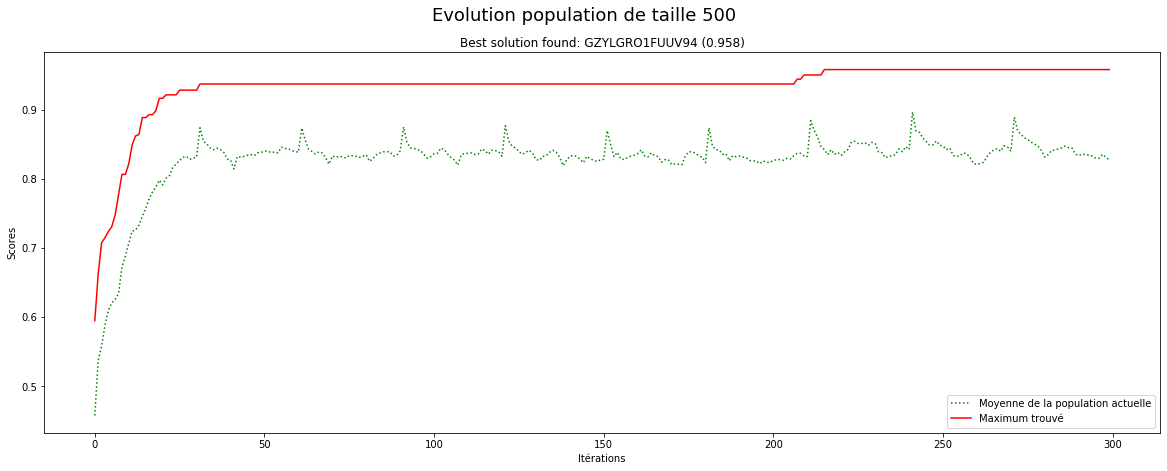

In [21]:
search(500, 300)

Best found: GZYLGRO1FHUHUV94 at Epoch 176/300!
Best solution found: GZYLGRO1FHUHUV94 (1.000)


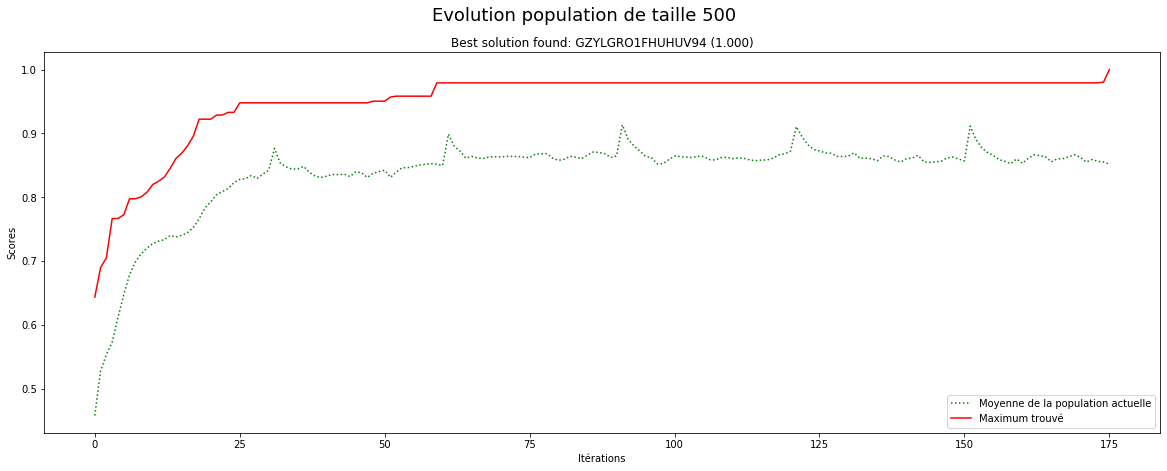

In [11]:
search(500, 300)

In [20]:
print('GZYLGRO1FHUHUV94 =',check(group_number=GROUP_ID, attempt='GZYLGRO1FHUHUV94'))
print("Mot de passe trouvé !")

GZYLGRO1FHUHUV94 = 1.0
Mot de passe trouvé !


Sur ce graphique, on peut apercevoir les fusions des différentes populations grâce au pic que connaît la moyenne de la population totale. Ceci s'explique par le fait que lors d'une fusion, certaines populations qui avaient "perdu" des gènes positifs au cours de leur évolution se retrouvent au contact du "gène manquant", ce qui augmente leur score et donc la moyenne de l'ensemble de la population.

On remarque également des périodes de stagnation entre les fusions et des fusions qui ont un impact limité (seule la 2e a produit un nouveau meilleur élément). On peut interpréter ceci par un manque de diversité génétique entre les reproducteurs des différentes populations. En effet, une sélection élitiste des reproducteurs induira une conservation de gènes très similaires dans des populations différentes. Ajouté à cela cette même sélection lors des fusions, on obtient une proportion plus importante de bons individus mais une diversité génétique plus faible.  
Pour compenser ceci, il faudrait mettre en place une sélection autre qu'élitiste, ou augmenter l'exploration entre les fusions, soit par une périodicité plus longue, soit par un nombre de mutations accru.

# Stats

In [15]:
configs = [
    {
        'population_size': 200,
        'epochs': 200,
        'mutation': NCharSeqNextPrevMutation(n=2),
        'cross_over': CrossOverRandomSliceTwo(0.6),
    },
    {
        'population_size': 500,
        'epochs': 200,
        'mutation': NCharSeqNextPrevMutation(n=2),
        'cross_over': CrossOverRandomSliceTwo(0.6),
    },
    {
        'population_size': 100,
        'epochs': 200,
        'mutation': NCharSeqNextPrevMutation(n=2),
        'cross_over': CrossOverRandomSliceTwo(0.6),
    }
]

In [16]:
def stats(configs, nb_repeats):
    to_plot = []
    for i, conf in enumerate(configs):
        print(i, conf)
        repeats = []
        for i in range(nb_repeats):
            exploration = SimpleExploration(conf['cross_over'],
                                            conf['mutation'],
                                            elite_size=conf['population_size'] // 10)
            population = Population(conf['population_size'], exploration=exploration)
            _, bests, _ = evolve_population(population, max_epochs=conf['epochs'], show_progress=False)
            repeats.append(bests)
        average = []
        for i in range(conf['epochs']):
            s = 0
            for r in repeats:
                s += r[i]
            average.append(s/nb_repeats)
        to_plot.append(average)

    for i, l in enumerate(to_plot):
        plt.plot(l, label=str(i))
    plt.xlabel('Itérations')
    plt.ylabel('Scores')
    plt.legend(loc="lower right")
    plt.show()

0 {'population_size': 200, 'epochs': 200, 'mutation': <mutations.NCharSeqNextPrevMutation object at 0x000001C215819C50>, 'cross_over': <cross_overs.CrossOverRandomSliceTwo object at 0x000001C2158E3C18>}
1 {'population_size': 500, 'epochs': 200, 'mutation': <mutations.NCharSeqNextPrevMutation object at 0x000001C2158E3CF8>, 'cross_over': <cross_overs.CrossOverRandomSliceTwo object at 0x000001C2158E3D30>}
2 {'population_size': 100, 'epochs': 200, 'mutation': <mutations.NCharSeqNextPrevMutation object at 0x000001C2158E3D68>, 'cross_over': <cross_overs.CrossOverRandomSliceTwo object at 0x000001C2158E3DA0>}


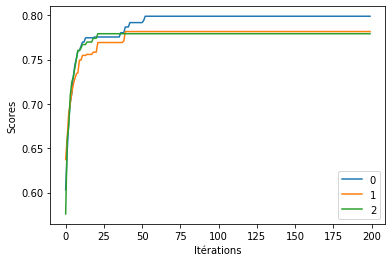

In [19]:
stats(configs, nb_repeats=3)